# Model Stuff

In [1]:
from ipynb.fs.full.functions import *

In [2]:
# Data to create our model
dfa = pd.read_csv('../data/ama_comments.csv')
dfb = pd.read_csv('../data/ar_comments.csv')
df = pd.concat([dfa, dfb], axis=0)
df = CleanUp(df).df.copy()

In [3]:
# Model X, and y
df = df.sample(n=df.shape[0], random_state=3)

X_other = df.drop(columns=['subreddit_binary', 'body'])
X = df['body']
y = df['subreddit_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [4]:
X_other_train, X_other_test, y_other_train, y_other_test = train_test_split(X_other, 
    y, stratify=y, random_state=3)


In [5]:
# TEST data (not part of train/test/split)
df1 = pd.read_csv('../data/2021-04-27_1812_AMA_comments.csv')
df2 = pd.read_csv('../data/2021-04-27_1812_AskReddit_comments.csv')
df_test_pred = pd.concat([df1, df2], axis=0)
df_test_pred = CleanUp(df_test_pred).df.copy()

In [6]:
df_test_pred = df_test_pred.sample(n=df_test_pred.shape[0], random_state=3)

X_other_new = df_test_pred.drop(columns=['subreddit_binary', 'body'])
X_new = df_test_pred['body']
y_new = df_test_pred['subreddit_binary'] 

In [26]:

gs_lgr_nobody = ClassificationModel(make_pipeline(
    LogisticRegression(), verbose=True), 
    X_other_train, X_other_test, y_other_train, y_other_test,
    params={
}, verbose=3, mod_name='Train/Test LogReg NoBody')

# gs_lgr_nobody.df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline]  (step 1 of 1) Processing logisticregression, total=   0.1s


In [27]:

gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf LogReg')

# gs_tv_lgr.df

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [28]:

gs_tv_gb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    GradientBoostingClassifier()), 
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf gBoost')

# gs_tv_gb.df

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [29]:

gs_cv_ab = ClassificationModel(make_pipeline(
    CountVectorizer(), 
    AdaBoostClassifier()), 
    X_train, X_test, y_train, y_test,
    params={
        'countvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'countvectorizer__stop_words': [ 'english', None ],
        'countvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test cVect adaBst')

# gs_cv_ab.df

Fitting 5 folds for each of 48 candidates, totalling 240 fits


### MAKE MODEL FUNCTION(S)

In [31]:
print(f'{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}')

(7370,), (2457,), (7370,), (2457,)


In [32]:
print(f'{X.shape}, {X_new.shape}, {y.shape}, {y_new.shape}')

(9827,), (1962,), (9827,), (1962,)


In [33]:
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

### GridSearch Voting Ensemble

In [143]:
vote_ada_gbst_lgr = VotingClassifier(
    [('ada', gs_cv_ab.model), 
     ('gbst', gs_tv_gb.model),
     ('lgr', gs_tv_lgr.model)],
    weights=[ 0.2, 0.2, 0.6 ]
)

In [144]:
vote_ada_gbst_lgr.fit_transform(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


array([[1, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [146]:
y_pred_vr_weights = vote_ada_gbst_lgr.predict(X_test)

f1_score(y_test, y_pred_vr_weights)

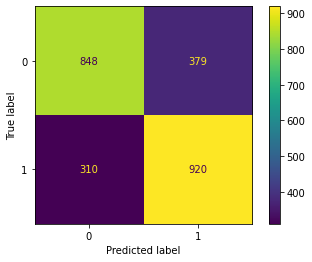

In [147]:
plot_confusion_matrix(vote_ada_gbst_lgr, X_test, y_test)

In [150]:
vote_ada_gbst_lgr.fit_transform(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


array([[1, 1, 1],
       [0, 0, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [0, 0, 0],
       [1, 1, 1]], dtype=int64)

In [151]:
y_pred_vr_weights = vote_ada_gbst_lgr.predict(X_new)

f1_score(y_new, y_pred_vr_weights)

0.6696078431372549

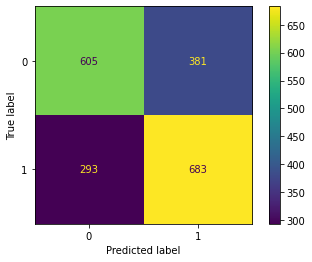

In [152]:
plot_confusion_matrix(vote_ada_gbst_lgr, X_new, y_new)

### Tfidf Voting Ensemble: 

In [153]:
tvect = TfidfVectorizer()
X_tvect_train = tvect.fit_transform(X_train)
X_tvect_test = tvect.transform(X_test)
X_tvect = tvect.transform(X)
X_tvect_new = tvect.transform(X_new)


In [130]:
v_ada_gbst_lgr_tvect = VotingClassifier(
    [('ada', AdaBoostClassifier()), 
     ('gbst', GradientBoostingClassifier()),
     ('lgr', LogisticRegression())],
    weights=[ 0.2, 0.2, 0.6 ]
)

In [131]:
v_ada_gbst_lgr_tvect.fit_transform(X_tvect_train, y_train)

array([[0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [149]:
y_v_ada_gbst_lgr_tvect_pred = v_ada_gbst_lgr_tvect.predict(X_tvect_test)

f1_score(y_test, y_v_ada_gbst_lgr_tvect_pred)

0.7317460317460318

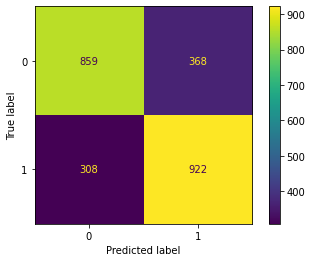

In [142]:
plot_confusion_matrix(v_ada_gbst_lgr_tvect, X_tvect_test, y_test) # 0.2, 0.2, 0.6

In [159]:
v_ada_gbst_lgr_tvect.fit_transform(X_tvect, y)

array([[1, 1, 1],
       [0, 0, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [0, 0, 0],
       [1, 1, 1]], dtype=int64)

In [160]:
y_v_ada_gbst_lgr_tvect_pred = v_ada_gbst_lgr_tvect.predict(X_tvect_new)

f1_score(y_new, y_v_ada_gbst_lgr_tvect_pred)

0.6699171136031203

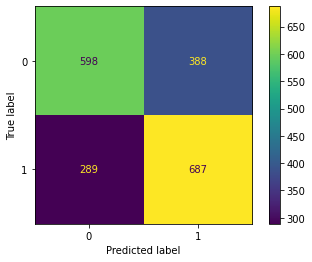

In [161]:
plot_confusion_matrix(v_ada_gbst_lgr_tvect, X_tvect_new, y_new) # 0.2, 0.2, 0.6

### Tfidf Voting Ensemble: 
This time with some trees

In [201]:
v_tree_lgr_tvect = VotingClassifier(
    [('tree', DecisionTreeClassifier()),
     ('lgr', LogisticRegression())],
    weights=[ 0.2, 0.8 ]
)

In [202]:
v_tree_lgr_tvect.fit_transform(X_tvect_train, y_train)

array([[0, 0],
       [0, 0],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]], dtype=int64)

In [203]:
y_v_tree_lgr_tvect_pred = v_tree_lgr_tvect.predict(X_tvect_test)

f1_score(y_test, y_v_tree_lgr_tvect_pred)

0.7317460317460318

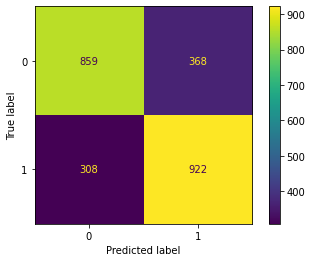

In [204]:
plot_confusion_matrix(v_tree_lgr_tvect, X_tvect_test, y_test) # 0.2, 0.2, 0.6

In [205]:
v_tree_lgr_tvect.fit_transform(X_tvect, y)

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [0, 0],
       [1, 1]], dtype=int64)

In [206]:
y_v_tree_lgr_tvect_pred = v_tree_lgr_tvect.predict(X_tvect_new)

f1_score(y_new, y_v_tree_lgr_tvect_pred)

0.6699171136031203

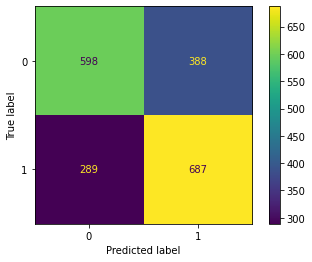

In [207]:
plot_confusion_matrix(v_tree_lgr_tvect, X_tvect_new, y_new) # 0.2, 0.2, 0.6

In [211]:
v_rfc_lgr_tvect = VotingClassifier(
    [('rfc', RandomForestClassifier()),
     ('lgr', LogisticRegression())],
    weights=[ 0.2, 0.8 ]
)

In [212]:
v_rfc_lgr_tvect.fit_transform(X_tvect_train, y_train)

array([[0, 0],
       [0, 0],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]], dtype=int64)

In [213]:
y_v_rfc_lgr_tvect_pred = v_rfc_lgr_tvect.predict(X_tvect_test)

f1_score(y_test, y_v_rfc_lgr_tvect_pred)

0.7317460317460318

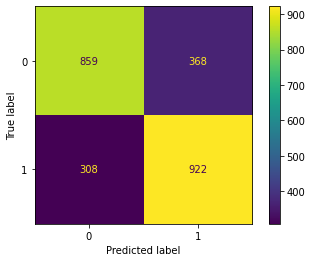

In [214]:
plot_confusion_matrix(v_rfc_lgr_tvect, X_tvect_test, y_test) # 0.2, 0.2, 0.6

In [215]:
v_rfc_lgr_tvect.fit_transform(X_tvect, y)

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [0, 0],
       [1, 1]], dtype=int64)

In [216]:
y_v_rfc_lgr_tvect_pred = v_rfc_lgr_tvect.predict(X_tvect_new)

f1_score(y_new, y_v_rfc_lgr_tvect_pred)

0.6699171136031203

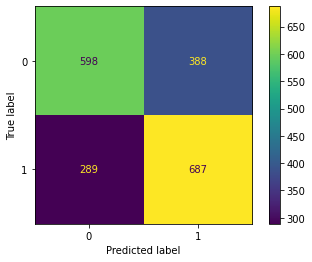

In [217]:
plot_confusion_matrix(v_rfc_lgr_tvect, X_tvect_new, y_new) # 0.2, 0.2, 0.6

In [221]:
print_classification_stats(y_new, y_v_rfc_lgr_tvect_pred)

{'F1 Score': 0.6699171136031203,
 'Recall Score': 0.7038934426229508,
 'Accuracy Score': 0.6549439347604485,
 'Balanced Accuracy': 0.6551921574169521,
 'Precision Score': 0.6390697674418605,
 'True Positive': 687,
 'False Negative': 289,
 'False Positive': 388,
 'True Negative': 598,
 'Calculated Accuracy': 0.6549439347604485,
 'Calculated Precision': 0.6390697674418605,
 'Calculated Sensitivity': 0.7038934426229508,
 'Calculated Specificity': 0.6064908722109533}

In [222]:
print_classification_stats(y_test, v_rfc_lgr_tvect.predict(X_tvect_test))

{'F1 Score': 0.8215867901731776,
 'Recall Score': 0.8292682926829268,
 'Accuracy Score': 0.8196988196988197,
 'Balanced Accuracy': 0.8196871210765897,
 'Precision Score': 0.8140462889066241,
 'True Positive': 1020,
 'False Negative': 210,
 'False Positive': 233,
 'True Negative': 994,
 'Calculated Accuracy': 0.8196988196988197,
 'Calculated Precision': 0.8140462889066241,
 'Calculated Sensitivity': 0.8292682926829268,
 'Calculated Specificity': 0.8101059494702526}

### CVect Voting Ensemble

In [154]:
cvect = CountVectorizer()
X_cvect_train = cvect.fit_transform(X_train)
X_cvect_test = cvect.transform(X_test)
X_cvect = cvect.fit_transform(X)
X_cvect_new = cvect.transform(X_new)


In [135]:
v_ada_gbst_lgr_cvect = VotingClassifier(
    [('ada', AdaBoostClassifier()), 
     ('gbst', GradientBoostingClassifier()),
     ('lgr', LogisticRegression())],
    weights=[ 0.2, 0.2, 0.6 ]
)

In [162]:
v_ada_gbst_lgr_cvect.fit_transform(X_cvect, y)

array([[1, 1, 1],
       [0, 0, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [0, 0, 0],
       [1, 1, 1]], dtype=int64)

In [163]:
y_v_ada_gbst_lgr_cvect_pred = v_ada_gbst_lgr_cvect.predict(X_cvect_new)

f1_score(y_new, y_v_ada_gbst_lgr_cvect_pred)

0.6499754540991655

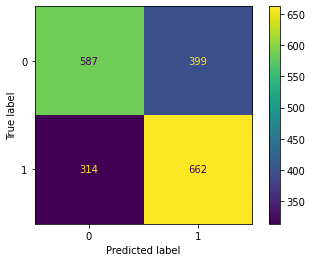

In [164]:
plot_confusion_matrix(v_ada_gbst_lgr_cvect, X_cvect_new, y_new) # 0.2, 0.2, 0.6

In [165]:
v_ada_gbst_lgr_cvect.fit_transform(X_cvect_train, y_train)

array([[0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [166]:
y_v_ada_gbst_lgr_cvect_pred = v_ada_gbst_lgr_cvect.predict(X_cvect_test)

f1_score(y_test, y_v_ada_gbst_lgr_cvect_pred)

0.7266272189349113

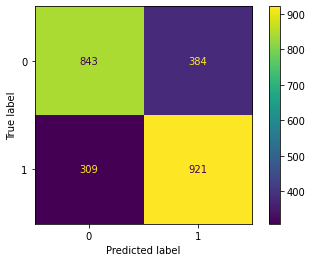

In [167]:
plot_confusion_matrix(v_ada_gbst_lgr_cvect, X_cvect_test, y_test) # 0.2, 0.2, 0.6

In [ ]:
from IPython.lib.display import Audio
framerate = 4410
play_time_seconds = 3
t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*261*t) + np.sin(2*np.pi*440*t) + np.sin(4*np.pi*440*t) + np.sin(4*np.pi*261*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [218]:
### Did this run??